In [1]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms, datasets
from torchvision.models import resnet50, ResNet50_Weights
from torchsummary import summary
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
class MyOwnCifar(torch.utils.data.Dataset):
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

### Задание 1. Обучите CNN (самописная) на CIFAR-100

In [3]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)

Files already downloaded and verified


In [4]:
classes = dataset.classes
print(classes)
print()
print(len(classes))

['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree',

In [5]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4),
                                    transforms.ToTensor()])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)

valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)

torch.Size([128, 3, 32, 32])
bus


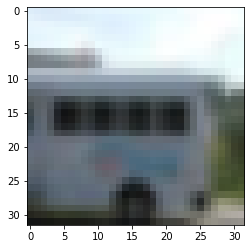

In [6]:
for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[0]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dp_three = nn.Dropout(0.1)
        self.dp_four = nn.Dropout(0.2)
        self.bn_one = torch.nn.BatchNorm2d(3)
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30)
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(2160, 1080)
        self.fc2 = torch.nn.Linear(1080, 540)
        self.out = torch.nn.Linear(540, 100)

    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.bn_three(x)
        x = x.view(x.size(0), -1)
        x = self.dp_three(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_four(x)
        x = self.fc2(x)
        x = F.relu(x)

        return self.out(x)

net = Net()
print(net)

Net(
  (dp_three): Dropout(p=0.1, inplace=False)
  (dp_four): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2160, out_features=1080, bias=True)
  (fc2): Linear(in_features=1080, out_features=540, bias=True)
  (out): Linear(in_features=540, out_features=100, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [9]:
summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
           Dropout-6                 [-1, 2160]               0
            Linear-7                 [-1, 1080]       2,333,880
           Dropout-8                 [-1, 1080]               0
            Linear-9                  [-1, 540]         583,740
           Linear-10                  [-1, 100]          54,100
Total params: 2,989,006
Trainable params: 2,989,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.41
Params size (MB): 11.40
Estima

In [10]:
num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    net.train()
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            
            for i, data in enumerate(valid_loader):
                test_outputs = net(data[0])
                test_running_total += len(data[1])
                test_running_right += (data[1] == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch [1/5]. Step [1/371]. Loss: 0.036. Acc: 0.008. Test acc: 0.006
Epoch [1/5]. Step [301/371]. Loss: 0.034. Acc: 0.039. Test acc: 0.067


 20%|████████████████▊                                                                   | 1/5 [00:29<01:56, 29.24s/it]

Epoch [2/5]. Step [1/371]. Loss: 2.387. Acc: 0.023. Test acc: 0.032
Epoch [2/5]. Step [301/371]. Loss: 0.037. Acc: 0.010. Test acc: 0.008


 40%|█████████████████████████████████▌                                                  | 2/5 [00:59<01:28, 29.57s/it]

Epoch [3/5]. Step [1/371]. Loss: 70.983. Acc: 0.008. Test acc: 0.007
Epoch [3/5]. Step [301/371]. Loss: 0.037. Acc: 0.009. Test acc: 0.007


 60%|██████████████████████████████████████████████████▍                                 | 3/5 [01:29<01:00, 30.06s/it]

Epoch [4/5]. Step [1/371]. Loss: 2.152. Acc: 0.008. Test acc: 0.010
Epoch [4/5]. Step [301/371]. Loss: 0.036. Acc: 0.010. Test acc: 0.009


 80%|███████████████████████████████████████████████████████████████████▏                | 4/5 [02:00<00:30, 30.41s/it]

Epoch [5/5]. Step [1/371]. Loss: 0.188. Acc: 0.016. Test acc: 0.011
Epoch [5/5]. Step [301/371]. Loss: 0.036. Acc: 0.009. Test acc: 0.010


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:34<00:00, 30.87s/it]

Training is finished!


### Задание 2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50

In [11]:
resnet50 = resnet50(weights=ResNet50_Weights.DEFAULT)

In [12]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                normalize,
                                transforms.ToTensor()])

In [13]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.set_parameter_requires_grad = False

In [14]:
set_parameter_requires_grad(resnet50, True)
resnet50.fc = nn.Linear(2048, 100)

In [15]:
trans_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)

valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           drop_last=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)

In [16]:
params_to_update = []

for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer = torch.optim.Adam(params_to_update, lr=0.01)
criterion = nn.CrossEntropyLoss()

In [17]:
summary(resnet50, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [ ]:
num_epochs = 5

for epoch in tqdm(range(num_epochs)):
    resnet50.train()
    
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            
            for i, data in enumerate(valid_loader):
                test_outputs = resnet50(data[0])
                test_running_total += len(data[1])
                test_running_right += (data[1] == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
print('Training is finished!')

  0%|                                                                                            | 0/5 [00:00<?, ?it/s]

Epoch [1/5]. Step [1/371]. Loss: 0.036. Acc: 0.000. Test acc: 0.009


### Задание 3. Сравните результаты обучения на эквивалентном числе эпох

С resnet50 не прогружается дальше первой строчки даже в colab с cuda. Но видно, что accuracy на тесте сразу чуть выше. Вероятно, с resnet50 loss должна быть ниже, а точность выше на эквивалентном числе эпох.